# Algorithm Examples for Temperature Computation in Order-Disorder Phase Transitions

This notebook presents a collection of algorithms designed to compute the temperature of the order-disorder phase transition in a 4x4 square lattice with four adsorbed particles. The following methods are implemented to achieve this:

1. **Exact Enumeration of Microstates**: This method exhaustively enumerates all possible microstates of the system to calculate thermodynamic properties.
2. **Markov Chain Monte Carlo (MCMC) Simulations**: Utilizing stochastic sampling techniques, MCMC simulations explore the phase space to estimate the temperature of the phase transition.
3. **Wang-Landau Sampling**: This advanced algorithm enhances the exploration of energy states by iteratively updating the density of states, providing an efficient way to determine the phase transition temperature.

All algorithms are implemented within the NVT ensemble, where the number of particles (N), volume (V), and temperature (T) are held constant throughout the simulations.

In [1]:
using FreeBird
using Plots
using Statistics
using Distributions
using DataFrames
using CSV

## Define the System

The system under consideration is a 4x4x2 simple cubic lattice with four particles. The lattice sites are indexed from 1 to 32, as shown below. The lattice exhibits periodic boundary conditions in the x and y directions, but not in the z direction.

### Lattice Sites
- Lattice sites 1 to 16 represent adsorbed particles ($z - z_{\text{surface}} = 0$).
- Lattice sites 17 to 32 represent desorbed particles ($z > z_{\text{surface}}$).

### Lattice Structure

#### Layer 1 (Adsorbed particles, $z - z_{\text{surface}} = 0$)
```
  1  2  3  4
  5  6  7  8
  9 10 11 12
 13 14 15 16
```

#### Layer 2 (Desorbed particles, $z > z_{\text{surface}}$)
```
 17 18 19 20
 21 22 23 24
 25 26 27 28
 29 30 31 32
```

### Nearest and Next-Nearest Neighbors
- A particle is considered a nearest neighbor to another particle if it is within 1.1 units of distance.
- Particles are classified as next-nearest neighbors if they are within 1.5 units of distance.

In this cubic lattice:
- Nearest neighbors include particles directly adjacent in the x, y, or z directions.
- Next-nearest neighbors include particles that are one site away diagonally in the x, y, or z directions.

Since there are no periodic boundary conditions in the z direction, particles in layer 1 (sites 1-16) do not interact periodically with particles in layer 2 (sites 17-32).

In [2]:
# Define a simple cubic lattice
lattice_constant = 1.0
primitive_lattice_vectors = [lattice_constant 0 0; 0 lattice_constant 0; 0 0 lattice_constant]
basis = [(0.0, 0.0, 0.0)]
supercell_dimensions = (4, 4, 2)
periodicity = (true, true, false)
num_total_sites = supercell_dimensions[1]*supercell_dimensions[2]*supercell_dimensions[3]*length(basis)
occupations = [true for i in 1:num_total_sites]
adsorptions = vcat(fill(true, 16), fill(false, num_total_sites - 16))
cutoff_radii = (1.1, 1.5)
lattice = LatticeSystem(
    primitive_lattice_vectors,
    basis,
    supercell_dimensions,
    periodicity,
    occupations,
    adsorptions,
    cutoff_radii
)

# Define parameters
K = supercell_dimensions[1]
L = supercell_dimensions[2]
M = supercell_dimensions[3]
Ns = [4]
adsorption_energy = -0.04  # eV
nn_energy = -0.01  # eV
nnn_energy = -0.0025  # eV

-0.0025

In [3]:
# # test
# # Define a simple cubic lattice
# lattice_constant = 1.0
# primitive_lattice_vectors = [lattice_constant 0 0; 0 lattice_constant 0; 0 0 lattice_constant]
# basis = [(0.0, 0.0, 0.0)]
# supercell_dimensions = (4, 4, 2)
# periodicity = (true, true, false)
# num_total_sites = supercell_dimensions[1]*supercell_dimensions[2]*supercell_dimensions[3]*length(basis)
# occupations = [false for i in 1:num_total_sites]
# occupations[1] = true
# occupations[18] = true
# adsorptions = vcat(fill(true, 16), fill(false, num_total_sites - 16))
# cutoff_radii = (1.1, 1.5)
# lattice = LatticeSystem(
#     primitive_lattice_vectors,
#     basis,
#     supercell_dimensions,
#     periodicity,
#     occupations,
#     adsorptions,
#     cutoff_radii
# )
# adsorption_energy = -0.04  # eV
# nn_energy = -0.01  # eV
# nnn_energy = -0.0025  # eV
# cutoff_radii = (1.1, 1.1)
# E = AbstractWalkers.interaction_energy(lattice, adsorption_energy, nn_energy, nnn_energy)
# println(E)

# # results
# # nearest neighbors
# # occupations[1] = true
# # occupations[2] = true
# # E = -0.09 = 2*(-0.04) + 1*(-0.01) = 2*adsorption_energy + 1*nn_energy

# # next nearest neighbors
# # occupations[1] = true
# # occupations[6] = true
# # E = -0.0825 = 2*(-0.04) + 1*(-0.0025) = 2*adsorption_energy + 1*nnn_energy

# # nearest neighbor adsorbed and desorbed sites
# # occupations[1] = true
# # occupations[17] = true
# # E = -0.05 = 1*(-0.04) + 1*(-0.01) = 1*adsorption_energy + 1*nn_energy

# # next nearest neighbor adsorbed and desorbed sites
# # occupations[1] = true
# # occupations[18] = true
# # E = -0.0425 = 1*(-0.04) + 1*(-0.0025) = 1*adsorption_energy + 1*nnn_energy

## Exact Enumeration of Microstates

In [4]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for exact enumeration
parameters = "exact_simple_cubic_K$(K)_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"
microstates_file = "data/microstates_$parameters.csv"

# Perform exact enumeration if data files do not exist
if !isfile(cv_file) || !isfile(microstates_file)
    df_Cv = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[])
    df_microstates = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Any[])

    for N in Ns
        # Perform exact enumeration
        energies, configurations = exact_enumeration(
            primitive_lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            N,
            adsorptions,
            adsorption_energy,
            nn_energy,
            nnn_energy,
            cutoff_radii
        )

        # Define temperature range and corresponding beta values
        Ts = collect(1.0:0.1:1600.0)  # Temperatures in K
        βs = 1.0 ./ (k_B * Ts)  # 1/eV

        # Prepare energy values for Cv calculation
        ωis = ones(length(energies))
        Eis = [ustrip(energy) for energy in energies]
        dof = 0

        # Calculate Cv for each temperature
        Cv_values = [cv(β, ωis, Eis, dof) / k_B for β in βs]  # Cv in units of kB

        # Append Cv data to DataFrame
        append!(df_Cv, DataFrame(N = N, K = K, L = L, M = M, β = βs, T = Ts, Cv = Cv_values))

        # Append energy configurations data to DataFrame
        for i in 1:length(energies)
            append!(df_microstates, DataFrame(N = N, K = K, L = L, M = M, energy = energies[i], configurations = configurations[i]))
        end
    end

    # Write DataFrames to CSV files
    CSV.write(cv_file, df_Cv)
    CSV.write(microstates_file, df_microstates)
else
    println("Data files already exist.")
end

Data files already exist.


## MCMC Algorithm

The Markov Chain Monte Carlo (MCMC) algorithm used in this study is based on the Metropolis-Hastings algorithm. The transition probability from state $i$ to state $j$ is given by:
$$
P \left( i \rightarrow j \right) = \min{\left[ 1, e^{-\beta \left( E_j - E_i \right)} \right]}
$$
where $E_i$ is the energy of state $i$ and $\beta = \frac{1}{k_{\text{B}} T}$ is the inverse temperature, with $k_{\text{B}}$ being the Boltzmann constant and $T$ the temperature.

### Hamiltonian

The Hamiltonian of the system is expressed as:
$$
H = N \varepsilon_{\text{ads}} + \sum_{\text{NN}} \varepsilon_{\text{NN}} + \sum_{\text{NNN}} \varepsilon_{\text{NNN}}
$$
where $N$ is the number of adsorbed particles, $\varepsilon_{\text{ads}}$ is the energy of an adsorbed particle, $\varepsilon_{\text{NN}}$ is the energy of nearest neighbors, and $\varepsilon_{\text{NNN}}$ is the energy of next-nearest neighbors. The values of these energies are:

$$
\begin{align*}
    \varepsilon_{\text{ads}} &= 4 \varepsilon_{\text{NN}} \\
    \varepsilon_{\text{NN}} &= -0.01 \, \text{eV} \\
    \varepsilon_{\text{NNN}} &= \frac{\varepsilon_{\text{NN}}}{4}
\end{align*}
$$

These values approximate the Lennard-Jones potential for Argon atoms adsorbed on a solid Argon substrate.

### Algorithm

The MCMC algorithm proceeds as follows:

1. **Initialize**: Set the system to a random initial state.
2. **Random Move**: Select a random particle and attempt to move it to a random neighboring site (if the site is empty).
3. **Energy Calculation**: Compute the energy difference $\Delta E = E_j - E_i$.
4. **Acceptance Criterion**: Accept the move with the probability $P \left( i \rightarrow j \right)$.
5. **Iterate**: Repeat steps 2-4 for a large number of iterations to ensure convergence.

This algorithm allows us to efficiently sample the phase space and estimate the temperature of the order-disorder phase transition in the system.

Data files already exist.


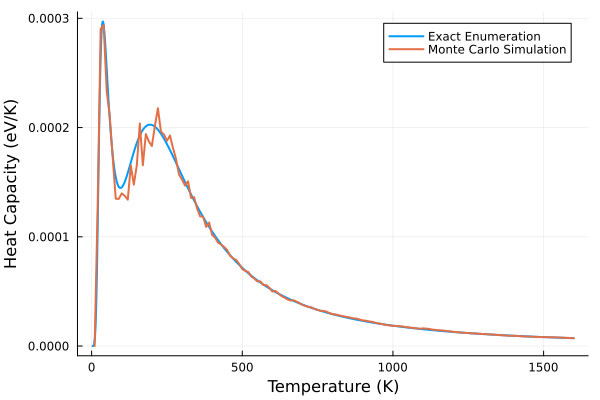

In [5]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for MCMC simulation
temperatures = 1600:-10:10  # 200:-1:1
num_equilibration_steps = 10_000
num_sampling_steps = 10_000
random_seed = 1234

# Define file paths for data
parameters = "mc_simple_cubic_K$(K)_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"

# Perform the Monte Carlo simulation if data files do not exist
if !isfile(cv_file)

    # Initialize a DataFrame to store the results
    df_samples = DataFrame(N = Int[], T = Float64[], E = Float64[], Cv = Float64[], acceptance_rate = Float64[])
    
    # Perform the Monte Carlo simulation
    for N in Ns
        println("N = $N -------------------")

        # Initialize the lattice
        occupations = [false for i in 1:num_total_sites]
        for i in sample(1:length(occupations), N, replace=false)
            occupations[i] = true
        end
        initial_lattice = LatticeSystem(
            primitive_lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            occupations,
            adsorptions,
            cutoff_radii
        )

        for temp in temperatures
            println("T = $temp")

            # Equilibrate the lattice
            temperature = Float64(temp)
            equilibration_energies, equilibration_configurations, equilibration_accepted_steps = nvt_monte_carlo(
                initial_lattice,
                adsorption_energy,
                nn_energy,
                nnn_energy,
                temperature,
                num_equilibration_steps,
                random_seed
            )

            # Sample the lattice
            sampling_energies, sampling_configurations, sampling_accepted_steps = nvt_monte_carlo(
                equilibration_configurations[end],
                adsorption_energy,
                nn_energy,
                nnn_energy,
                temperature,
                num_sampling_steps,
                random_seed
            )

            # Compute the heat capacity
            E = mean(sampling_energies)
            Cv = var(sampling_energies) / (k_B * temperature^2)

            # Compute the acceptance rate
            acceptance_rate = sampling_accepted_steps / num_sampling_steps

            # Append the results to the DataFrame
            append!(df_samples, DataFrame(N = N, T = temperature, E = E, Cv = Cv, acceptance_rate = acceptance_rate))

            # Update the initial lattice
            initial_lattice = deepcopy(sampling_configurations[end])
        end
    end

    # Write DataFrame to a CSV file
    CSV.write(cv_file, df_samples)
else
    println("Data files already exist.")
end

# Read data from CSV files
df_exact = CSV.read("data/Cv_exact_simple_cubic_K4_L4_M2_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)
df_mcmc = CSV.read("data/Cv_mc_simple_cubic_K4_L4_M2_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Plot the heat capacity
plot(df_exact.T, df_exact.Cv * k_B, label="Exact Enumeration", xlabel="Temperature (K)", ylabel="Heat Capacity (eV/K)", legend=:topright, lw=2)
plot!(df_mcmc.T, df_mcmc.Cv, label="Monte Carlo Simulation", lw=2)

## Wang-Landau Sampling

The Wang-Landau algorithm is an advanced Monte Carlo method that iteratively updates the density of states or the microcanonical entropy to enhance the exploration of energy states. This algorithm is particularly useful for computing the entropy and free energy of systems with complex energy landscapes. The key idea is to iteratively adjust the density of states $g(E)$ or the microcanonical entropy $S(E)$ to ensure uniform sampling of all energy states.

### Algorithm

The Wang-Landau algorithm proceeds as follows:

1. **Initialize**: Set the system to a random initial state and initialize the microcanonical entropy $S(E)$.
2. **Random Move**: Select a random particle and attempt to move it to a random neighboring site (if the site is empty).
3. **Ratio Calculation**: Compute the ratio $\eta = \frac{g(E_i)}{g(E_f)}$, where $E_i$ and $E_f$ are the initial and final energies, respectively.
4. **Acceptance Criterion**: Accept the move with probability $\min{\left[ 1, \eta \right]}$.
5. **Update Microcanonical Entropy**: If the move is accepted, update the microcanonical entropy $S(E)$ as $S(E) \leftarrow S(E) + \ln{f}$, where $f$ is the modification factor.
6. **Histogram Check**: Check if the histogram of energy states has converged. If it hasn't, repeat steps 2-5. If the histogram has converged, update the modification factor $f \leftarrow \sqrt{f}$ and reset the histogram.
7. **Iterate**: Repeat steps 2-6 for a large number of iterations to ensure thorough convergence.

This approach allows for efficient sampling of energy states and provides accurate estimates of the entropy and free energy for systems with complex energy landscapes.

In [4]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for Wang-Landau simulation
num_steps = 100
flatness_criterion = 0.8
f_initial = Float64(MathConstants.e)
f_min = exp(10^-8)
energy_min = 20.5 * nn_energy + nn_energy / 8
energy_max = 16 * nn_energy - nn_energy / 8
num_energy_bins = 100
energy_bins = collect(range(energy_min, stop=energy_max, length=num_energy_bins))

# Initialize the lattice
square_occupations = [false for i in 1:square_supercell_dimensions[1]*square_supercell_dimensions[2]*length(square_basis)]
for i in sample(1:length(square_occupations), 4, replace=false)
    square_occupations[i] = true
end
initial_lattice = LatticeSystem(
    square_primitive_lattice_vectors,
    square_basis,
    square_supercell_dimensions,
    square_periodicity,
    square_occupations,
    square_adsorptions,
    square_cutoff_radii
)

# Define file paths for data
parameters = "wl_square_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(square_cutoff_radii[1])_$(square_cutoff_radii[2])"
entropy_file = "data/entropy_$parameters.csv"

# Perform the Wang-Landau simulation if data files do not exist
if !isfile(entropy_file)
    entropy, histogram, bin_energies, energies, configurations = wang_landau(
        initial_lattice,
        adsorption_energy,
        nn_energy,
        nnn_energy,
        num_steps,
        flatness_criterion,
        f_initial,
        f_min,
        energy_bins,
        random_seed
    )

    # Write the entropy to a CSV file
    df_entropy = DataFrame(energy = bin_energies, entropy = entropy)
    CSV.write(entropy_file, df_entropy)
else
    println("Data files already exist.")
end

Data files already exist.


### Analyzing the Results

#### Density of States

The density of states $g(E)$ can be computed from the microcanonical entropy $S(E)$ using the relation:
$$
g(E) = e^{S(E)}
$$

Since $e^{S(E)}$ can result in very large numbers, it is often practical to shift the entropy by a constant factor before exponentiating. This shift does not alter the relative values of the density of states and helps maintain numerical stability.

For example, if $S'(E)$ represents the shifted entropy, then:
$$
g(E) = e^{S'(E)}
$$

where $S'(E) = S(E) - S_0$ and $S_0$ is a constant chosen for convenience. This adjustment ensures that the calculations remain manageable and accurate.

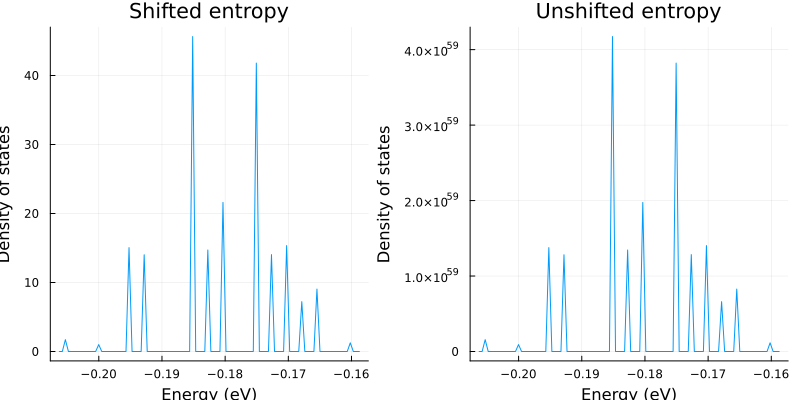

In [5]:
df_wl = CSV.read(entropy_file, DataFrame)
S_shifted = df_wl.entropy .- minimum(df_wl.entropy[df_wl.entropy .> 0])
g = exp.(S_shifted)
E = df_wl.energy

# Plot g(E)
p1 = plot(E, g, xlabel="Energy (eV)", ylabel="Density of states", legend=false, title="Shifted entropy")

# Plot exp.(df_entropy.entropy)
p2 = plot(E, exp.(df_wl.entropy), xlabel="Energy (eV)", ylabel="Density of states", legend=false, title="Unshifted entropy")

# Display the plots
plot(p1, p2, layout=(1, 2), size=(800, 400))

#### Ensemble Averages

The ensemble averages of various thermodynamic properties can be computed using the density of states. For instance, the average energy $\langle E \rangle$ and the specific heat $C_V$ can be calculated as follows:

The average energy $\langle E \rangle$ is given by:
$$
\langle E \rangle = \frac{\sum_{E} E g(E) e^{-\beta E}}{\sum_{E} g(E) e^{-\beta E}}
$$

The specific heat $C_V$ at constant volume is calculated using the fluctuations in energy:
$$
C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_{\text{B}} T^2}
$$

where $\langle E^2 \rangle$ is the ensemble average of the square of the energy, defined as:
$$
\langle E^2 \rangle = \frac{\sum_{E} E^2 g(E) e^{-\beta E}}{\sum_{E} g(E) e^{-\beta E}}
$$

In [6]:
# Compute the partition function as a function of temperature
E_rel = E .- minimum(E)
T = collect(1.0:0.1:200.0)
Z = zeros(length(T))
for (i, temp) in enumerate(T)
    Z[i] = sum(exp.(-E_rel ./ (k_B * temp)) .* g)
end

# Plot the partition function
# plot(T, Z, xlabel="Temperature (K)", ylabel="Partition function", legend=false, title="Partition function")

# Compute the average energy as a function of temperature
E_avg = zeros(length(T))
for (i, temp) in enumerate(T)
    E_avg[i] = sum(E_rel .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
end

# Plot the average energy
# plot(T, E_avg, xlabel="Temperature (K)", ylabel="Average energy (eV)", legend=false, title="Average energy")

# Compute the average energy squared as a function of temperature
E2_avg = zeros(length(T))
for (i, temp) in enumerate(T)
    E2_avg[i] = sum(E_rel.^2 .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
end

# Compute the heat capacity as a function of temperature
Cv = (E2_avg .- E_avg.^2) ./ (k_B * T.^2) / k_B

1991-element Vector{Float64}:
  0.0
 -2.3567263848445467e-14
 -9.90152404743716e-15
  1.6873603110425453e-14
 -7.27458909607628e-15
  0.0
  1.1139214553366803e-14
  1.67743466215406e-13
  1.1309740800850443e-12
  6.058745307431243e-12
  ⋮
  0.2766701859279931
  0.2763916719068337
  0.2761135686177017
  0.2758358752722573
  0.27555859108400665
  0.2752817152682956
  0.2750052470423019
  0.2747291856250321
  0.27445353023731983

## Nested Sampling

Nested sampling is a powerful algorithm for computing the evidence or marginal likelihood of a model given the data. In the context of statistical physics, nested sampling can be used to estimate the partition function of a system, which is essential for calculating thermodynamic properties.

### Algorithm

The nested sampling algorithm proceeds as follows:

1. **Initialize**: 
    - Generate an initial ensemble of $N$ configurations from a prior distribution.
    - Compute the energy of each configuration.

2. **Sort by Energy**: 
    - Sort the configurations by their energy in ascending order.
    - Identify and store the configuration with the highest energy, $E_{\text{max}}$, as the current maximum energy.

3. **Generate New Configuration**: 
    - Generate a new configuration uniformly from the prior distribution, constrained to have an energy less than or equal to $E_{\text{max}}$.

4. **Replace Configuration**: 
    - Replace the configuration with the highest energy in the ensemble with the newly generated configuration if it satisfies the energy constraint.

5. **Update Maximum Energy**: 
    - Re-compute and store the new maximum energy $E_{\text{max}}$ of the updated ensemble.

6. **Repeat**: 
    - Repeat steps 3-5 until a convergence criterion is met, such as a specified number of iterations or a change in $E_{\text{max}}$ below a certain threshold.

Data files already exist.


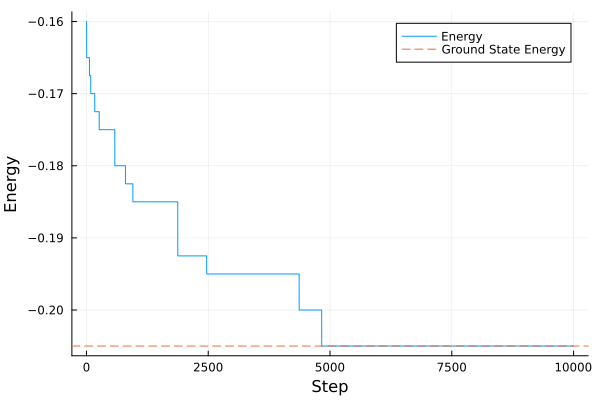

In [7]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Initialize walkers with random configurations
num_walkers = 1000
walkers = [deepcopy(initial_lattice) for i in 1:num_walkers]
for walker in walkers
    walker.occupations = [false for i in 1:length(walker.occupations)]
    for i in sample(1:length(walker.occupations), 4, replace=false)
        walker.occupations[i] = true
    end
end

# Define parameters for nested sampling simulation
num_steps = 10000
perturbation = 1e-10

# Define file paths for data
parameters = "ns_square_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(square_cutoff_radii[1])_$(square_cutoff_radii[2])"
energy_file = "data/energy_$parameters.csv"

# Perform the nested sampling simulation if data files do not exist
if !isfile(energy_file)
    results = nested_sampling(
        walkers,
        num_steps,
        adsorption_energy,
        nn_energy,
        nnn_energy,
        perturbation
    )

    # Write the energy to a CSV file
    df_energy = DataFrame(step = 1:num_steps, energy = results[3])
    CSV.write(energy_file, df_energy)
else
    println("Data files already exist.")
end

# Plot the results
df_ns = CSV.read(energy_file, DataFrame)
plot(df_ns.energy, xlabel="Step", ylabel="Energy", label="Energy")

# Add a horizontal line for the ground state energy
ground_state_energy = 20.5 * nn_energy
hline!([ground_state_energy], label="Ground State Energy", linestyle=:dash)

### Analyzing the Results

#### Partition Function

The partition function $Z$ can be computed from the results of nested sampling. It is defined as:
$$
Z = \sum_i \omega_i e^{-\beta E_i}
$$
where
$$
\omega_i = \frac{1}{K + 1} \left( \frac{K}{K + 1} \right)^i
$$
and $K$ is the number of walkers in the nested sampling algorithm.

#### Ensemble Averages

The average energy $\langle E \rangle$ and the specific heat $C_V$ can be computed using the partition function. The average energy is given by:
$$
\langle E \rangle = \frac{1}{Z} \sum_i E_i \omega_i e^{-\beta E_i}
$$

The average energy squared $\langle E^2 \rangle$ is calculated as:
$$
\langle E^2 \rangle = \frac{1}{Z} \sum_i E_i^2 \omega_i e^{-\beta E_i}
$$

In [8]:
# Compute ω_i
ω_0 = 16 * 15 * 14 * 13 / 4 / 3 / 2 / 1  # 16 choose 4
ω_i = ω_0 * (1 / num_walkers) * (num_walkers / (num_walkers + 1)) .^ (collect(1:num_steps))

# Compute the partition function as a function of temperature
Z = zeros(length(T))
E_i_ns = df_ns.energy
E_rel_i_ns = E_i_ns .- minimum(E_i_ns)
for (i, temp) in enumerate(T)
    Z[i] = sum(exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i)
end

# Compute the average energy as a function of temperature
E_avg_i_ns = zeros(length(T))
for (i, temp) in enumerate(T)
    E_avg_i_ns[i] = sum(E_rel_i_ns .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
end

# Compute the average energy squared as a function of temperature
E2_avg_i_ns = zeros(length(T))
for (i, temp) in enumerate(T)
    E2_avg_i_ns[i] = sum(E_rel_i_ns.^2 .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
end

# Compute the heat capacity as a function of temperature
Cv_i_ns = (E2_avg_i_ns .- E_avg_i_ns.^2) ./ (k_B * T.^2) / k_B

1991-element Vector{Float64}:
 1.0790451782508405e-13
 8.917730765617771e-14
 7.493507939310394e-14
 6.389755133087135e-14
 5.6071755666922725e-14
 6.201648770079673e-14
 1.8077739714171258e-13
 1.0739590839256624e-12
 6.191682275889103e-12
 3.018173293411991e-11
 ⋮
 0.271814526375257
 0.2715410611228207
 0.27126799956666553
 0.27099534092982985
 0.270723084437173
 0.2704512293153796
 0.27017977479294797
 0.2699087201001897
 0.26963806446922023

## Replica Exchange

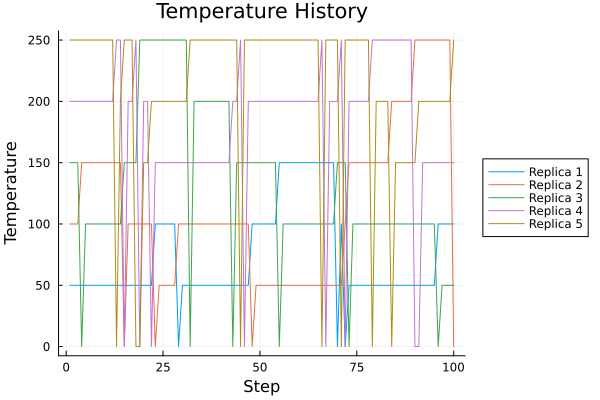

Bool[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Bool[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Bool[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Bool[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Bool[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


In [9]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Initialize replicas with random configurations
num_replicas = 5
replicas = [deepcopy(initial_lattice) for _ in 1:num_replicas]
for replica in replicas
    replica.occupations = [false for i in 1:length(replica.occupations)]
    for i in sample(1:length(replica.occupations), 4, replace=false)
        replica.occupations[i] = true
    end
end

# Define parameters for replica exchange simulation
temperatures = [50., 100., 150., 200., 250.]  # K
num_steps = 100  # 10000
swap_fraction = 0.1  # 10% swap, 90% displacement
for replica in replicas
    println(replica.occupations)
end

# Run the simulation
replicas, energies, temperature_history = nvt_replica_exchange(
    replicas,
    temperatures,
    num_steps,
    adsorption_energy,
    nn_energy,
    nnn_energy,
    swap_fraction
)

# Plot the temperature history
p = plot(title="Temperature History", xlabel="Step", ylabel="Temperature", legend=:outerright)
for i in 1:num_replicas
    plot!(p, temperature_history[:, i], label="Replica $i")
end
display(p)

## Results

The temperature at which the maximum specific heat peak occurs is identified as the phase transition temperature. This peak signifies the onset of the order-disorder phase transition. 

The exact enumeration method serves as a benchmark for determining the phase transition temperature. In contrast, the MCMC and Wang-Landau algorithms provide efficient and accurate estimates of this temperature.

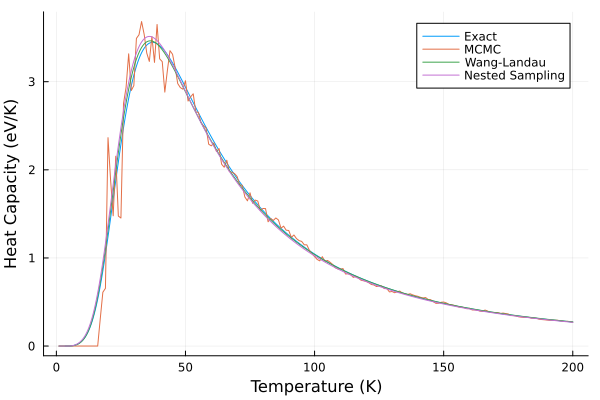

In [10]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read exact enumeration results
df_exact = CSV.read("data/Cv_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Read MCMC results
df_mcmc = CSV.read("data/Cv_mc_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Extract the data for N = 4
df_exact = filter(row -> row.N == 4, copy(df_exact))
df_mcmc = filter(row -> row.N == 4, copy(df_mcmc))

# Create a heat capacity vs. temperature plot with exact enumeration, MCMC, and Wang-Landau results
heat_capacity_plot = plot(df_exact.T, df_exact.Cv, xlabel="Temperature (K)", ylabel="Heat Capacity (eV/K)", label="Exact", grid=true)
plot!(heat_capacity_plot, df_mcmc.T, df_mcmc.Cv / k_B, label="MCMC")
plot!(heat_capacity_plot, T, Cv, label="Wang-Landau")
plot!(heat_capacity_plot, T, Cv_i_ns, label="Nested Sampling")

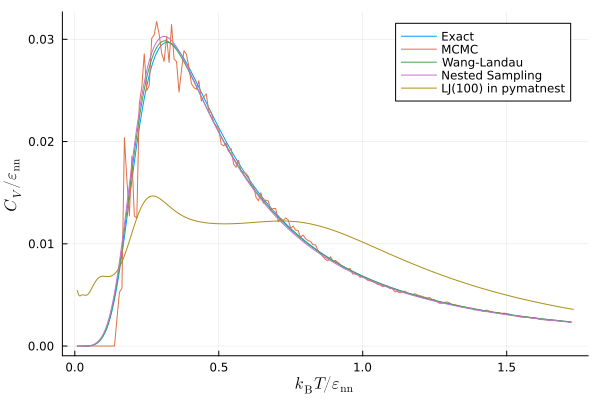

In [11]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read nested sampling results for LJ(100)
df_ns_lj100 = CSV.read("data/Cv_ns_LJ_100.csv", DataFrame)

# # Create a heat capacity vs. temperature plot with exact enumeration, MCMC, and Wang-Landau results
heat_capacity_plot = plot(df_exact.T * k_B / -nn_energy, df_exact.Cv * k_B / -nn_energy, xlabel="\$ k_{\\mathrm{B}} T / \\varepsilon_{\\mathrm{nn}} \$", ylabel="\$ C_V / \\varepsilon_{\\mathrm{nn}} \$", label="Exact", grid=true)
plot!(heat_capacity_plot, df_mcmc.T * k_B / -nn_energy, df_mcmc.Cv / -nn_energy, label="MCMC")
plot!(heat_capacity_plot, T * k_B / -nn_energy, Cv * k_B / -nn_energy, label="Wang-Landau")
plot!(heat_capacity_plot, T * k_B / -nn_energy, Cv_i_ns * k_B / -nn_energy, label="Nested Sampling")
plot!(heat_capacity_plot, df_ns_lj100.temp * k_B / 0.1, (df_ns_lj100.cv_eV_per_K .- (3 / 2 * 4 * k_B)) / 0.1, label="LJ(100) in pymatnest")